                             Time Series Analysis of GRP Data

In [1]:
## Data Processing

In [74]:
%matplotlib inline
import pandas as pd
data = pd.read_excel("ActualRatings_weeklyGRP.xls", sheet_name='TVRating_Data', index_col=0)
data.head()

,GRP
GRPRatingsDate,
17-Jun-2007 (25),243.60
24-Jun-2007 (26),263.19
01-Jul-2007 (27),269.89
08-Jul-2007 (28),252.88
15-Jul-2007 (29),303.46


In [75]:
data.tail(3)

,GRP
GRPRatingsDate,
01-Mar-2009 (10),208.56
08-Mar-2009 (11),191.74
15-Mar-2009 (12),222.07


In [76]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [77]:
data.index = data.index.str[:11]

In [78]:
data.index = pd.to_datetime(data.index)

In [79]:
data.columns

Index(['GRP'], dtype='object')

In [80]:
import plotly

In [81]:
plotly.tools.set_credentials_file(username='81santi81', api_key='YrIPfoUSq1ESCQ99NVNh')

In [82]:
data.head()

,GRP
GRPRatingsDate,
2007-06-17,243.60
2007-06-24,263.19
2007-07-01,269.89
2007-07-08,252.88
2007-07-15,303.46


In [83]:
ts = data['GRP'] 
ts.head(10)

GRPRatingsDate
2007-06-17    243.60
2007-06-24    263.19
2007-07-01    269.89
2007-07-08    252.88
2007-07-15    303.46
2007-07-22    286.29
2007-07-29    292.28
2007-08-05    288.72
2007-08-12    285.70
2007-08-19    286.01
Name: GRP, dtype: float64

In [84]:
#2. Use ':' if one of the indices is at ends:
training = ts[:'2008-10-26']

In [85]:
training.size

72

In [86]:
test = ts['2008-11-02':]

In [87]:
test.size

20

In [88]:
import plotly.plotly as ply
import cufflinks as cf
training.iplot(title="TRP Ratings Jul 2007 to Sep 2008")

In [89]:
import plotly.plotly as ply
import cufflinks as cf
test.iplot(title="TRP Ratings Nov 2008 to Mar 2009")

#### Check Stationarity  Time Series

A TS is said to be stationary if its statistical properties such as mean, variance remain constant over time. Most of the TS models work on the assumption that the TS is stationary. 

Stationarity is defined using very strict criterion. However, for practical purposes we can assume the series to be stationary if it has constant statistical properties over time, ie. the following:

    constant mean
    constant variance
    an autocovariance that does not depend on time.


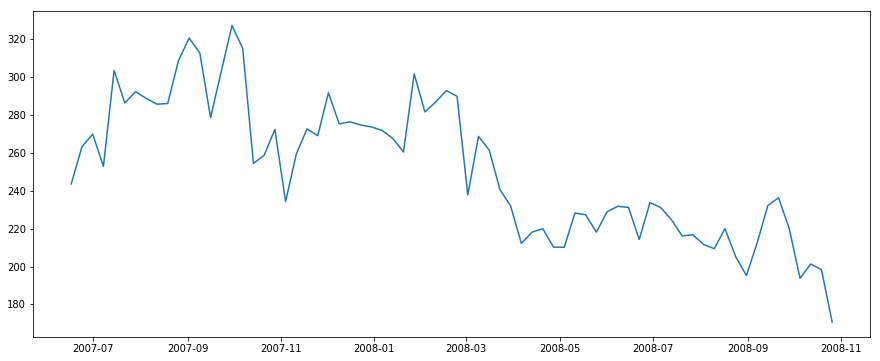

In [90]:
plt.plot(training)

It is clearly evident that there is an overall decreasing trend in the data along with some seasonal variations.So, more formally, we can check stationarity
using the following:



Plotting Rolling Statistics: We plotted the moving average or moving variance and see if it varies with time. By moving average/variance we mean that at any instant ‘t’, we’ll take the average/variance of the last month, i.e. last 4 instances.  

Dickey-Fuller Test: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. 


In [91]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(4).mean()
    rolstd = timeseries.rolling(4).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

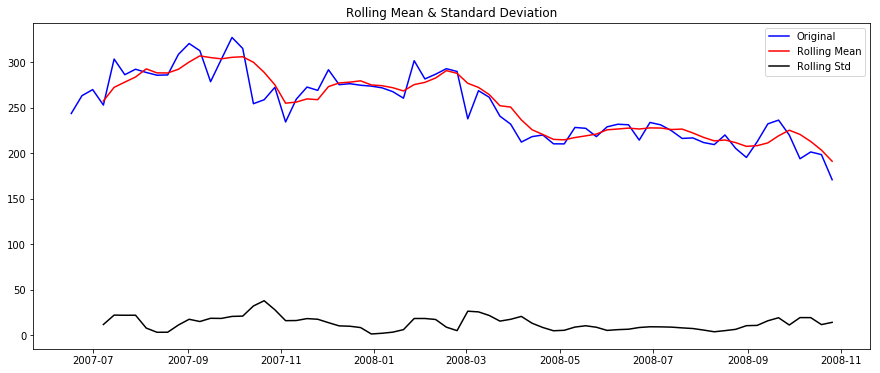

Results of Dickey-Fuller Test:
Test Statistic                 -0.521883
p-value                         0.887675
#Lags Used                      2.000000
Number of Observations Used    69.000000
Critical Value (1%)            -3.528890
Critical Value (5%)            -2.904440
Critical Value (10%)           -2.589656
dtype: float64


In [92]:
test_stationarity(training)

Though the variation in standard deviation is small, mean is clearly decreasing with time and this is not a stationary series. Also, the test statistic is way more than the critical values. 

#### Making  a Time Series Stationary?


There are 2 major reasons behind non-stationaruty of a TS:
1. Trend – varying mean over time. For eg, in this case we saw that on average, the rating was falling over time.

2. Seasonality – variations at specific time-frames. eg people might have a tendency to watch tv in  particular month because of holidays or festivals.

The underlying principle is to model or estimate the trend and seasonality in the series and remove those from the series to get a stationary series. Then statistical forecasting techniques can be implemented on this series. The final step would be to convert the forecasted values into the original scale by applying trend and seasonality constraints back.



#### Estimating & Eliminating Trend

One of the first tricks to reduce trend is transformation. For example, in this case we can clearly see that the there is a significant negative trend. So, we applied a transformation which penalized higher values more than smaller values by taking a log transform. 

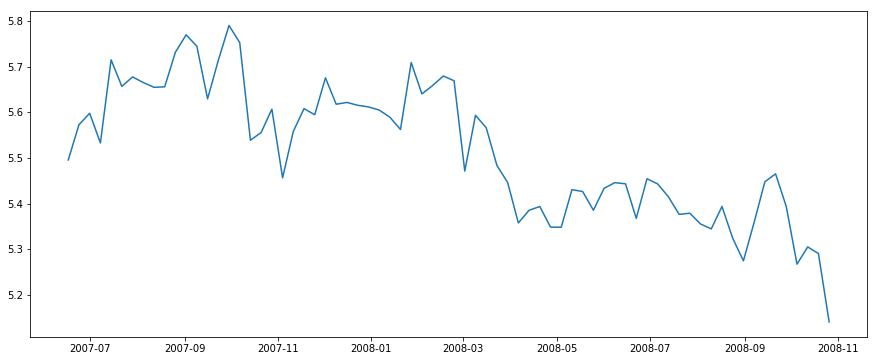

In [93]:
ts_log = np.log(training)
plt.plot(ts_log)

We see a downward trend in the data. But its not very intuitive in presence of noise. So we use some techniques to estimate or model this trend and then remove it from the series. 

There can be many ways of doing it but we primarily used :

    Smoothing – taking rolling averages


Smoothing refers to taking rolling estimates, i.e. considering the past few instances. 
    We primarily looked at Moving Average and Exponential Smoothing. 

#### Moving average
In this approach, we take average of ‘k’ consecutive values depending on the frequency of time series. Here we can take the average over the last 8 weeks, i.e. last 8 values. Pandas has specific functions defined for determining rolling statistics.

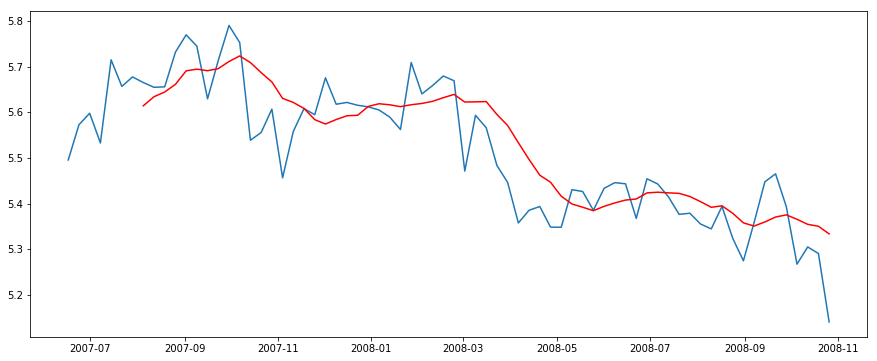

In [94]:
moving_avg = ts_log.rolling(8).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

The red line shows the rolling mean. Lets subtract this from the original series. Note that since we are taking average of last 8 values, rolling mean is not defined for first 7 values. This can be observed as:

In [95]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(8)

GRPRatingsDate
2007-06-17         NaN
2007-06-24         NaN
2007-07-01         NaN
2007-07-08         NaN
2007-07-15         NaN
2007-07-22         NaN
2007-07-29         NaN
2007-08-05    0.051113
Name: GRP, dtype: float64

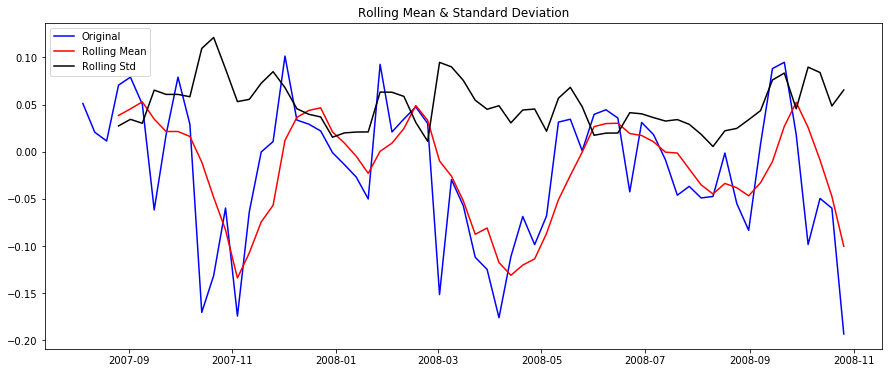

Results of Dickey-Fuller Test:
Test Statistic                 -3.573289
p-value                         0.006293
#Lags Used                      4.000000
Number of Observations Used    60.000000
Critical Value (1%)            -3.544369
Critical Value (5%)            -2.911073
Critical Value (10%)           -2.593190
dtype: float64


In [96]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

This looks like a better series. The rolling values appear to be varying  but there is no specific trend. Also, the test statistic is smaller than the 5% critical values so we can say with 95% confidence that this is a stationary series.

#### Exponential Smoothing

However, a drawback in this previous approach is that the time-period must be strictly defined.  So, we take a ‘weighted moving average’ where more recent values are given a higher weight. There can be many techniques for assigning weights. A popular one is exponentially weighted moving average where weights are assigned to all the previous values with a decay factor . This can be implemented in Pandas as:

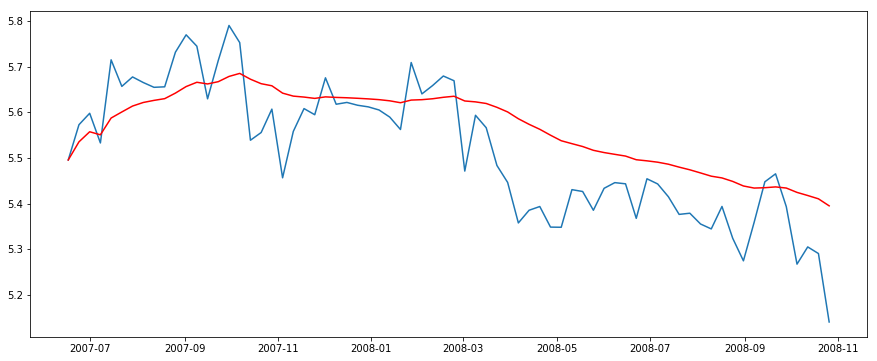

In [97]:
expwighted_avg = ts_log.ewm(halflife=12).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

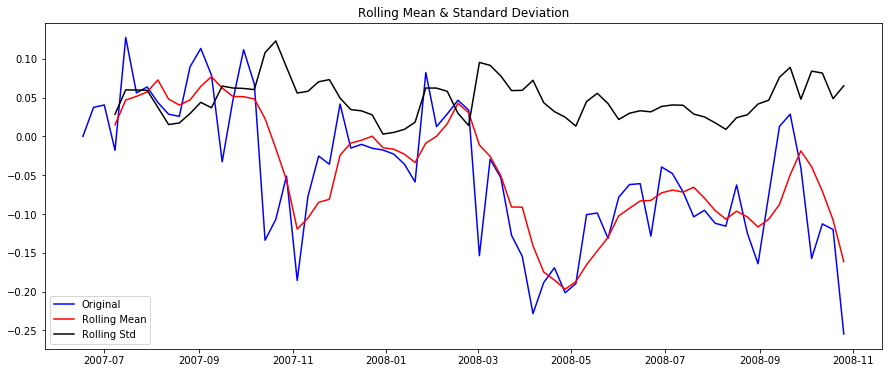

Results of Dickey-Fuller Test:
Test Statistic                 -3.111858
p-value                         0.025688
#Lags Used                      0.000000
Number of Observations Used    71.000000
Critical Value (1%)            -3.526005
Critical Value (5%)            -2.903200
Critical Value (10%)           -2.588995
dtype: float64


In [98]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

This Time Seris has even lesser variations in mean and standard deviation in magnitude. Also, the test statistic is smaller than the 5% critical value. 

#### Eliminating Trend and Seasonality
The simple trend reduction techniques discussed before don’t work in all cases, particularly the ones with high seasonality. Lets discuss two ways of removing trend and seasonality:

#### Differencing – taking the differece with a particular time lag
Decomposition – modeling both trend and seasonality and removing them from the model.

Differencing
One of the most common methods of dealing with both trend and seasonality is differencing. In this technique, we take the difference of the observation at a particular instant with that at the previous instant. This mostly works well in improving stationarity. First order differencing can be done in Pandas as:

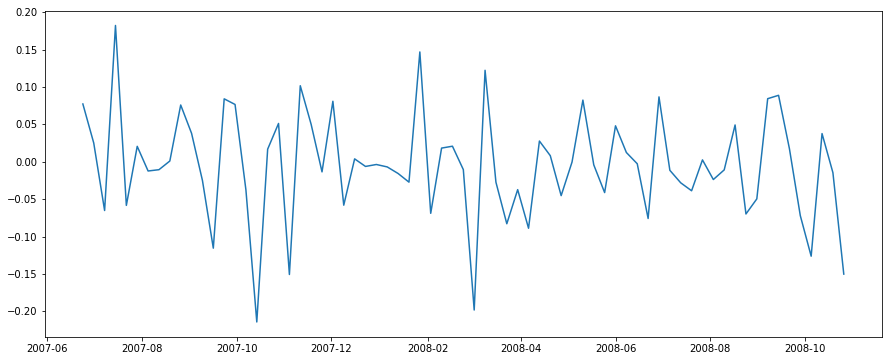

In [99]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

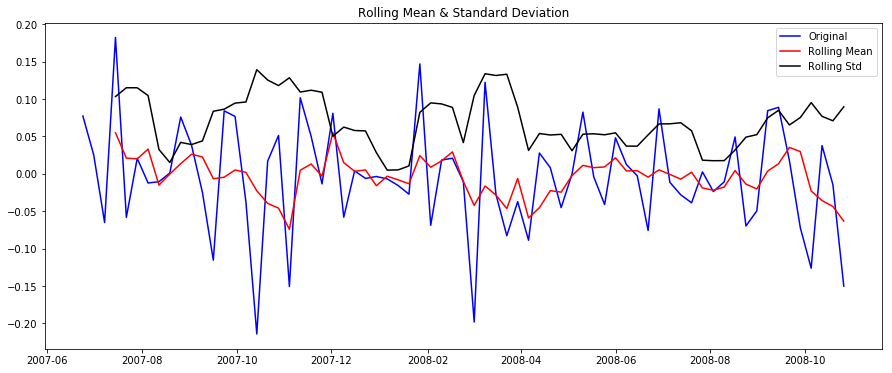

Results of Dickey-Fuller Test:
Test Statistic                -8.508060e+00
p-value                        1.187967e-13
#Lags Used                     1.000000e+00
Number of Observations Used    6.900000e+01
Critical Value (1%)           -3.528890e+00
Critical Value (5%)           -2.904440e+00
Critical Value (10%)          -2.589656e+00
dtype: float64


In [100]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

We can see that the mean and std variations have small variations with time. Also, the Dickey-Fuller test statistic is less than the 1% critical value, thus the TS is stationary with 99% confidence. 

Decomposing
In this approach, both trend and seasonality are modeled separately and the remaining part of the series is returned. 



In [116]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


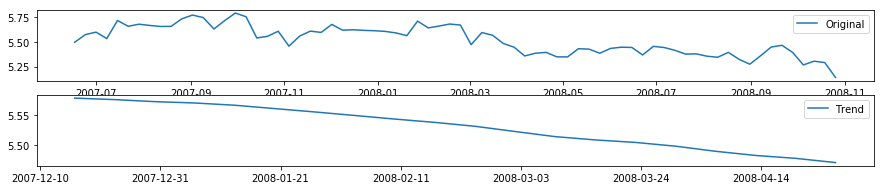

In [117]:
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')


#### Forecasting a Time Series

ARIMA stands for Auto-Regressive Integrated Moving Averages. The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model:

Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.

Number of Differences (d): These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.

An importance concern here is how to determine the value of ‘p’ and ‘q’. We use two plots to determine these numbers. 

Autocorrelation Function (ACF): It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).

Partial Autocorrelation Function (PACF): This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

The ACF and PACF plots for the TS after differencing can be plotted as:

In [118]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [119]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

Text(0.5,1,'Autocorrelation Function')

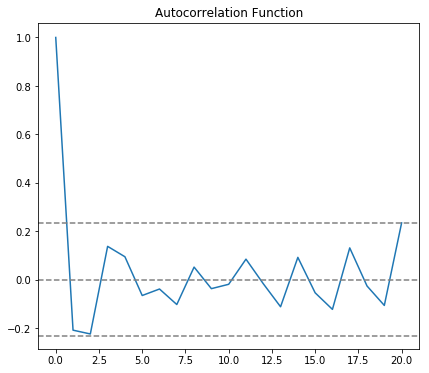

In [123]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

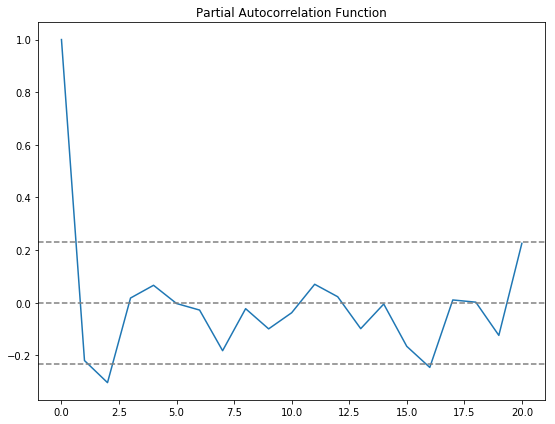

In [124]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [125]:
from statsmodels.tsa.arima_model import ARIMA

#### Arima Model

In [198]:
model = ARIMA(ts_log, order=(3, 0, 1))  
results_AR = model.fit(disp=-1)  

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



In [199]:
forecast = results_AR.forecast(steps=20)[0]

In [200]:
forecast

array([5.20026306, 5.23967074, 5.22254447, 5.23167969, 5.24774544,
       5.25281454, 5.25927458, 5.26804361, 5.2750672 , 5.28156399,
       5.28833163, 5.2947288 , 5.30076488, 5.3066459 , 5.31230921,
       5.31773011, 5.32295062, 5.32797646, 5.3328059 , 5.33745039])

In [201]:
predictions_ARIMA_diff = pd.Series(forecast, copy=True)
print(predictions_ARIMA_diff.head())

0    5.200263
1    5.239671
2    5.222544
3    5.231680
4    5.247745
dtype: float64


In [205]:
predictions_ARIMA_log = pd.Series(ts_log.ix[71], index=test.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff,fill_value=0)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated



In [206]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)


In [208]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [209]:
mean_absolute_percentage_error(test.values,predictions_ARIMA[20:].values)

4.612993917294163

In [210]:
results_AR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                    GRP   No. Observations:                   72
Model:                     ARMA(3, 1)   Log Likelihood                  90.693
Method:                       css-mle   S.D. of innovations              0.068
Date:                Mon, 17 Sep 2018   AIC                           -169.386
Time:                        04:37:34   BIC                           -155.726
Sample:                    06-17-2007   HQIC                          -163.948
                         - 10-26-2008                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.4542      0.111     49.003      0.000       5.236       5.672
ar.L1.GRP      0.5974      0.343      1.740      0.086      -0.076       1.270
ar.L2.GRP      0.0485      0.283      0.172      0.864      -0.505       0.602
ar.L3.GRP      0.2903      0.127      2.283      0.026       0.041       0.540
ma.L1.GRP      0.1000      0.347      0.288      0.774      -0.580       0.780
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0398           -0.0000j            1.0398           -0.0000
AR.2           -0.6035           -1.7172j            1.8201           -0.3038
AR.3           -0.6035           +1.7172j            1.8201            0.3038
MA.1          -10.0038           +0.0000j           10.0038            0.5000
-----------------------------------------------------------------------------
"""